## 직무 추천 알고리즘

> 코드 개요

이력서와 직무 정보 간의 유사도를 측정하여 상위 n개의 직무 추천

> 순서

이력서 데이터 구성
- 이력서의 주요 정보를 하나의 텍스트로 통합

직무 데이터 로드 및 전처리
- 직무 정보에서 권장 교육 수준을 숫자로 매핑하고, 유사도 측정을 위헤 텍스트 정리

적합도 점수 계산
- 점수는 총 4가지 요소로 구성하였으며 가중치는 현업 종사자에게 질문 및 서치를 통해 일정하게 배분

- 점수 요소

    1)자격증 매칭 점수

    2)경력 점수

    3)권장 교육 수준 점수

    4)TF-IDF와 BERT를 이용한 텍스트 유사도 점수

        단어의 빈도를 기반으로 비교하는 TF-IDF,  문장의 의미와 문맥을 파악하여 유사도를 계산하는 BERT를 함께 사용함으로써 정확도를 높이고자 하였음


### 알고리즘 코드

In [1]:
pip install sentence-transformers


   ---------------------------------------- 0.0/203.0 MB ? eta -:--:--
   ---------------------------------------- 1.0/203.0 MB 5.0 MB/s eta 0:00:41
   ---------------------------------------- 2.1/203.0 MB 5.3 MB/s eta 0:00:38
    --------------------------------------- 3.1/203.0 MB 5.4 MB/s eta 0:00:37
    --------------------------------------- 3.1/203.0 MB 5.4 MB/s eta 0:00:37
    --------------------------------------- 3.4/203.0 MB 3.3 MB/s eta 0:01:01
    --------------------------------------- 3.7/203.0 MB 3.0 MB/s eta 0:01:07
    --------------------------------------- 4.7/203.0 MB 3.1 MB/s eta 0:01:04
   - -------------------------------------- 6.0/203.0 MB 3.5 MB/s eta 0:00:57
   - -------------------------------------- 6.8/203.0 MB 3.6 MB/s eta 0:00:56
   - -------------------------------------- 7.9/203.0 MB 3.7 MB/s eta 0:00:54
   - -------------------------------------- 8.9/203.0 MB 3.8 MB/s eta 0:00:51
   - -------------------------------------- 8.9/203.0 MB 3.8 MB/s eta 0


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [36]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import re
from sentence_transformers import SentenceTransformer, util

# 이력서 데이터
data = {
    "personal_info": {
        "name": "재순신",
        "age": 30,
        "date_of_birth": "1994-05-21",
        "gender": "남성"
    },
    "education": {
        "high_school": {
            "school_name": "서울고등학교",
            "graduation_year": 2012
        },
        "university": {
            "school_name": "서울대학교",
            "department": "컴퓨터공학과",
            "entry_year": 2013,
            "graduation_year": 2017
        },
        "graduate_school": {
            "school_name": "카이스트",
            "department": "인공지능학과",
            "entry_year": 2018,
            "graduation_year": 2020
        }
    },
    "language_proficiency": {
        "languages": [
            {"language": "영어", "level": "상"},
            {"language": "일본어", "level": "중"}
        ],
        "test_scores": [
            {"test": "TOEIC", "score": 930, "test_date": "2019-08-21"},
            {"test": "OPIc", "score": "IH", "date": "2020-09-12"}
        ]
    },
    "certifications": [
        {"name": "정보처리기사", "date_obtained": "2020-03-15"},
        {"name": "데이터 분석 전문가", "date_obtained": "2021-05-12"},
        {"name": "TOEIC", "score": 930, "date_obtained": "2019-08-21"},
        {"name": "OPIc", "score": "IH", "date_obtained": "2020-09-12"}
    ],
    "tools": ["Git", "Excel", "Python", "C++", "TensorFlow", "Keras"],
    "work_experience": [
        {
            "company_name": "삼성전자",
            "industry": "전자",
            "department": "데이터 분석팀",
            "position": "데이터 분석가",
            "duration": "2021-01 ~ 2022-06",
            "main_tasks": "소비자 사용 데이터를 기반으로 제품 성능 개선을 위한 분석 수행. 대시보드를 정기적으로 업데이트하고, 사용자 피드백을 정량화하여 보고서 작성.",
            "achievements": "고객 만족도 15% 향상, 데이터 분석 기반의 신규 기능 추가 제안"
        }
    ],
    "internships": [
        {
            "company_name": "네이버",
            "industry": "IT",
            "position": "백엔드 개발",
            "duration": "2019-01 ~ 2019-06",
            "role": "네이버 쇼핑 API 개발 및 유지보수. 실시간 상품 검색 최적화, 상품 데이터베이스의 구조 개편 작업을 담당하여 데이터 접근 속도 개선에 기여."
        }
    ],
    "personal_activities": {
        "projects": [
            {
                "name": "개인 웹사이트 개발",
                "skills": ["HTML", "CSS", "JavaScript", "React"],
                "subject": "포트폴리오 웹사이트",
                "description": "HTML/CSS 및 JavaScript를 이용해 개인 포트폴리오 웹사이트를 개발. 사용자 인터페이스와 반응형 디자인 구현, React 기반의 컴포넌트 구조 설계.",
                "role": "프론트엔드 개발 및 전체 프로젝트 관리"
            },
            {
                "name": "자연어 처리(NLP) 기반 뉴스 요약기 개발",
                "skills": ["Python", "NLP", "TensorFlow"],
                "subject": "AI 뉴스 요약 시스템",
                "description": "텍스트 요약 알고리즘을 연구 및 개발하여 뉴스 요약 시스템을 구축. TensorFlow로 LSTM 기반의 요약 모델 학습 및 배포.",
                "role": "모델 설계 및 하이퍼파라미터 튜닝, 시스템 통합 작업"
            }
        ],
        "competitions": [
            {
                "name": "2019 데이터 분석 공모전",
                "subject": "건강 데이터 분석",
                "skills": ["Python", "R", "Data Visualization"],
                "description": "국민건강보험공단 제공 데이터를 분석하여 건강 지표와 연관성 도출. 데이터 전처리 및 시각화 작업을 수행하여 최종 보고서를 작성.",
                "role": "데이터 전처리 및 시각화, 분석 보고서 작성"
            },
            {
                "name": "2020 머신러닝 해커톤",
                "subject": "음성 감정 분석",
                "skills": ["Python", "Librosa", "Keras"],
                "description": "음성 데이터를 활용해 감정 상태를 예측하는 모델 개발. Librosa로 음성 특성 추출 후 LSTM 모델을 Keras로 구현하여 감정 상태를 분류.",
                "role": "데이터 수집 및 모델 개발, 발표 자료 준비"
            }
        ]
    },
    "awards": [
        {
            "award_name": "2019 데이터 분석 공모전 우승",
            "institution": "국민건강보험공단",
            "award_date": "2019-11-15"
        },
        {
            "award_name": "2020 머신러닝 해커톤 우수상",
            "institution": "AI Korea",
            "award_date": "2020-07-22"
        }
    ],
    "research_experience": [
        {
            "subject": "딥러닝 기반 이미지 분류 모델 개발",
            "main_results": "분류 정확도 92% 이상의 모델 개발, 논문 게재 및 학회 발표",
            "contribution": "모델 아키텍처 설계, 하이퍼파라미터 튜닝을 통한 성능 최적화, 학회 발표자료 작성 및 발표 담당"
        }
    ],
    "language_certifications_reference": {
        "English": ["TOEIC", "TOEFL iBT", "IELTS", "OPIc", "TEPS", "PTE Academic", "Cambridge English"],
        "Japanese": ["JLPT", "JPT", "BJT"]
    }
}

# 학력 매핑
education_levels = {
    "초졸 이하": 1,
    "중졸": 2,
    "고졸": 3,
    "전문대졸": 4,
    "대졸": 5,
    "대학원 이상": 6
}

# 학력 매핑 함수
def map_education_level(education_data):
    if "graduate_school" in education_data and education_data['graduate_school']['department']:
        return education_levels["대학원 이상"]
    elif "university" in education_data and education_data['university']['department']:
        return education_levels["대졸"]
    elif "high_school" in education_data:
        return education_levels["고졸"]
    else:
        return education_levels["중졸"]

# 학력 수준 추출
resume_education_level = map_education_level(data['education'])

# 직무 데이터 로드
job_data_updated = pd.read_csv('../데이터/직무정보_cleaned_영어.csv')

# 권장 교육 수준을 숫자로 매핑
job_data_updated['권장 교육수준 점수'] = job_data_updated['권장 교육수준'].map(education_levels)

# 권장 교육 수준 필터링
def within_one_level(resume_level, job_level):
    return abs(resume_level - job_level) <= 1

job_data_updated = job_data_updated[job_data_updated['권장 교육수준 점수'].apply(
    lambda job_level: within_one_level(resume_education_level, job_level)
)]

def education_score(resume_level, job_level):
    if resume_level == job_level:
        return 1.0
    elif resume_level > job_level:
        return 0.6
    else:
        return max(0, (resume_level / job_level) * 0.4)

job_data_updated['education_score'] = job_data_updated['권장 교육수준 점수'].apply(
    lambda job_level: education_score(resume_education_level, job_level)
)

# 경력 연수 계산
def calculate_experience_years(duration):
    match = re.match(r'(\d{4})-(\d{2}) ~ (\d{4})-(\d{2})', duration)
    if match:
        start_year = int(match.group(1))
        end_year = int(match.group(3))
        return end_year - start_year
    return 0

resume_experience_years = sum(calculate_experience_years(exp['duration']) for exp in data['work_experience'])

# 추가된 이력서 정보 (계속)
resume_education = data['education']['graduate_school']['department']
resume_skills = ", ".join(data['tools'])
resume_languages = ", ".join([lang['language'] for lang in data['language_proficiency']['languages']])
resume_certifications = [cert['name'] for cert in data['certifications']]
resume_main_tasks = data['work_experience'][0]['main_tasks']
resume_achievements = data['work_experience'][0]['achievements']

# Research Experience 추가
resume_research = " ".join([exp['subject'] + " " + exp['main_results'] + " " + exp['contribution'] for exp in data['research_experience']])

# Awards 추가
resume_awards = " ".join([award['award_name'] for award in data['awards']])

# Language Certifications Reference 추가
resume_language_certs = " ".join([" ".join(certs) for certs in data['language_certifications_reference'].values()])

# 수행 직무에 포함될 이력서 정보 통합
resume_full_text = " ".join([
    resume_education, resume_skills, resume_languages,
    resume_main_tasks, resume_achievements,
    resume_research, resume_awards, resume_language_certs
])

# TF-IDF 벡터화 (N-gram 활용)
job_descriptions = job_data_updated['직무개요_cleaned'] + " " + job_data_updated['수행직무_cleaned']
vectorizer = TfidfVectorizer(ngram_range=(1, 2))
job_tfidf = vectorizer.fit_transform(job_descriptions)

# 이력서 텍스트 데이터
resume_vector = vectorizer.transform([resume_full_text])

# 코사인 유사도 계산 (TF-IDF)
tfidf_similarity_scores = cosine_similarity(resume_vector, job_tfidf)[0]

# Sentence-BERT 모델을 사용하여 유사도 계산
bert_model = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2')
resume_embedding = bert_model.encode(resume_full_text, convert_to_tensor=True)
job_embeddings = bert_model.encode(job_descriptions.tolist(), convert_to_tensor=True)

bert_similarity_scores = util.pytorch_cos_sim(resume_embedding, job_embeddings).squeeze().cpu().numpy()

# 자격증 매칭 점수 계산
job_data_updated['cert_match'] = job_data_updated['자격/면허'].apply(
    lambda x: sum(cert in resume_certifications for cert in str(x).split(','))
)

# 권장 숙련기간_최소 문자열에서 개월 수 추출
def parse_experience_to_months(experience_str):
    if pd.isna(experience_str):
        return 0
    match_years = re.search(r'(\d+)년', experience_str)
    match_months = re.search(r'(\d+)개월', experience_str)

    years = int(match_years.group(1)) * 12 if match_years else 0
    months = int(match_months.group(1)) if match_months else 0

    return years + months

job_data_updated['권장 숙련기간_최소_개월'] = job_data_updated['권장 숙련기간_최소'].apply(parse_experience_to_months)
resume_experience_months = resume_experience_years * 12  # 이력서 경력을 개월로 변환

# 경력 점수 계산 (차이를 기반으로 점수화)
def experience_difference_score(resume_months, required_months):
    if required_months == 0:
        return 1  # 권장 숙련기간이 없는 경우 기본적으로 높은 점수
    difference = resume_months - required_months
    if difference >= 0:
        return 1  # 경력이 충분하면 최대 점수
    return max(0, 1 + (difference / required_months))  # 부족한 만큼 점수 감소

job_data_updated['experience_score'] = job_data_updated['권장 숙련기간_최소_개월'].apply(
    lambda min_months: experience_difference_score(resume_experience_months, min_months)
)

# BERT 유사도 점수 추가
job_data_updated['bert_similarity_score'] = bert_similarity_scores
# TF-IDF 유사도 점수 추가
job_data_updated['tfidf_similarity_score'] = tfidf_similarity_scores

# 최종 점수 계산
job_data_updated['total_score'] = (
    job_data_updated['cert_match'] * 0.15 +  # 자격증 매칭
    job_data_updated['experience_score'] * 0.10 +  # 경력 점수
    job_data_updated['tfidf_similarity_score'] * 0.20 +  # TF-IDF 기반 텍스트 유사도
    job_data_updated['bert_similarity_score'] * 0.20 +  # BERT 기반 텍스트 유사도
    job_data_updated['education_score'] * 0.35  # 권장 교육 수준 점수
)

# 상위 10개 직무 추천
top_n_jobs = job_data_updated.nlargest(20, 'total_score')
(top_n_jobs[['직무명', 'total_score', 'bert_similarity_score', 'tfidf_similarity_score', '자격/면허']].rename(
    columns={'total_score': '적합도 점수', 'bert_similarity_score': 'BERT 유사도 점수', 'tfidf_similarity_score': 'TF-IDF 유사도 점수', '자격/면허': '추천 자격증/면허증'}
))

,직무명,적합도 점수,BERT 유사도 점수,TF-IDF 유사도 점수,추천 자격증/면허증
1327,디지털트윈엔지니어,0.612408,0.382532,0.054509,"정보처리기사, 임베디드기사, 빅데이터분석기사, 전자계산기조직응용기사, 정보관리기술사..."
2480,생체인식전문가,0.587323,0.636614,0.000000,"정보처리기사, 정보통신기사, 전파통신기사, 방송통신기사, 전파전자기사"
5793,프로그램매뉴얼제작자,0.585309,0.603052,0.023494,"정보처리기사, 전자계산기조직응용기사"
5331,컴퓨터소프트웨어유지원,0.578690,0.593450,0.000000,정보처리기사
4031,인지과학연구원,0.577899,0.625971,0.013525,NaN
4567,정보기술컨설턴트,0.571469,0.592189,0.015154,NaN
1317,디지털영상처리시스템개발자,0.569884,0.544389,0.005032,"정보처리기사, 정보통신기사, 전파통신기사, 방송통신기사, 전파전자기사"
2865,스마트그리드표준화연구원,0.569280,0.594514,0.001887,NaN
3672,웹프로그래머,0.568282,0.530889,0.010523,정보처리기사
4918,지식관리시스템전문가,0.567499,0.532501,0.004993,정보처리기사


### 적합도 점수 시각화

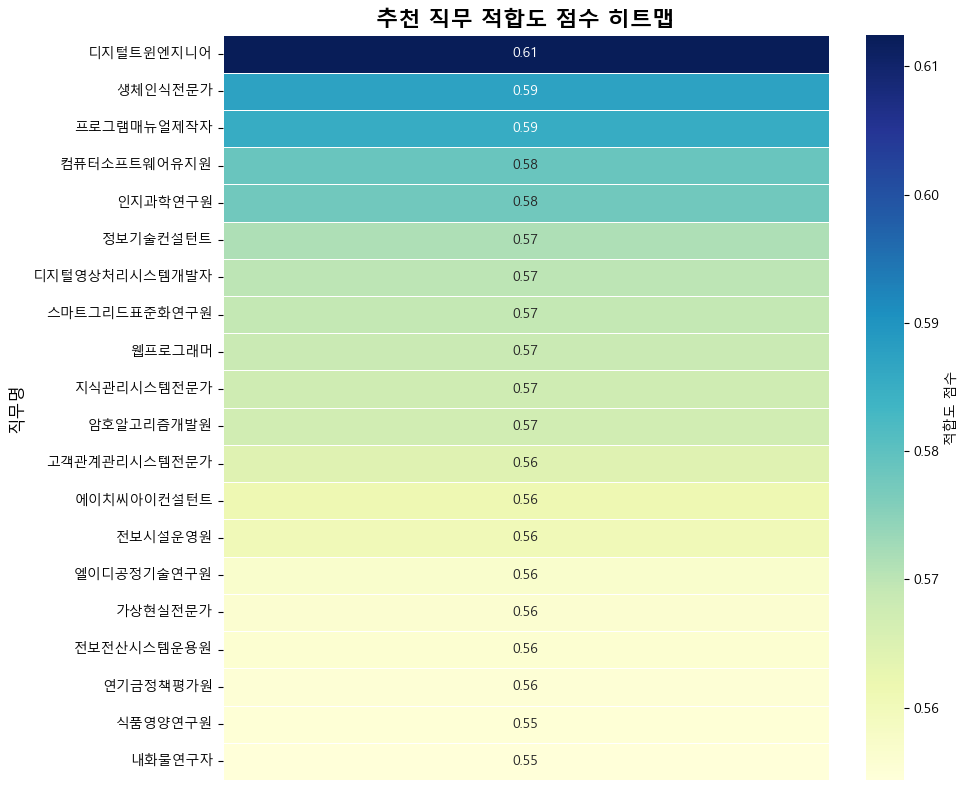

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt

# 적합도 점수 히트맵 시각화 함수
def visualize_recommendations_heatmap(recommended_jobs):
    """추천된 직무 정보를 적합도 점수 기준으로 히트맵으로 시각화"""
    plt.figure(figsize=(10, 8))

    # 필요한 컬럼만 추출하여 인덱스 설정
    heatmap_data = recommended_jobs[['직무명', 'total_score']].set_index('직무명')
    heatmap_data = heatmap_data.rename(columns={'total_score': '적합도 점수'})

    # 히트맵 그리기
    sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap="YlGnBu", linewidths=0.5, cbar_kws={'label': '적합도 점수'})
    plt.title("추천 직무 적합도 점수 히트맵", fontsize=16, fontweight='bold')
    plt.xlabel("")
    plt.ylabel("직무명", fontsize=12)
    plt.xticks([])
    plt.tight_layout()
    plt.show()

# 히트맵 시각화 함수 호출
visualize_recommendations_heatmap(top_n_jobs)
